<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/main/Projet_1_%E2%80%93_Pr%C3%A9diction_de_l%E2%80%99%C3%A9ligibilit%C3%A9_%C3%A0_un_pr%C3%AAt_bancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Prédiction Éligibilité Prêt
Objectif : prédire si un client est éligible à un prêt bancaire.

# Etape 1 : Compréhension et préparation des données

* Pour avoir la dataset automatiquement avec Kaggle API

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aicha224","key":"73c1e040f8d55a169c99b1f93cf1d529"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ninzaami/loan-predication

Dataset URL: https://www.kaggle.com/datasets/ninzaami/loan-predication
License(s): CC0-1.0
  0% 0.00/7.83k [00:00<?, ?B/s]
100% 7.83k/7.83k [00:00<00:00, 29.0MB/s]


In [4]:
!unzip loan-predication.zip

Archive:  loan-predication.zip
  inflating: train_u6lujuX_CVtuZ9i (1).csv  


In [5]:
!mv "train_u6lujuX_CVtuZ9i (1).csv" train.csv

## 1 - Import des librairies

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2 - Chargement du dataset

In [7]:
# Charger les données
df = pd.read_csv("train.csv")


| Nom de la colonne   | Signification en français                          |
| ------------------- | -------------------------------------------------- |
| `Loan_ID`           | Identifiant du prêt                                |
| `Gender`            | Sexe du demandeur (Male/Female)                    |
| `Married`           | Marié(e) ou non (Yes/No)                           |
| `Dependents`        | Nombre de personnes à charge                       |
| `Education`         | Niveau d’éducation (Graduate/Not Graduate)         |
| `Self_Employed`     | Travailleur indépendant (Yes/No)                   |
| `ApplicantIncome`   | Revenu du demandeur principal                      |
| `CoapplicantIncome` | Revenu du co-demandeur (s’il y a un co-emprunteur) |
| `LoanAmount`        | Montant du prêt demandé (en milliers)              |
| `Loan_Amount_Term`  | Durée du prêt (en mois)                            |
| `Credit_History`    | Historique de crédit (1 = bon, 0 = mauvais)        |
| `Property_Area`     | Zone de résidence (Urban / Semiurban / Rural)      |
| `Loan_Status`       | Statut du prêt (Y = accordé / N = refusé)          |


In [8]:
# Voir en-têtes
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 3 - Exploration initiale

In [9]:
# Informations générales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Valeurs manquantes
df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [11]:
# Vérifier doublons
df.duplicated().sum()

np.int64(0)

#### Remarque sur le dataset

- Le dataset contient **614 clients** et **13 colonnes(variables)**.  

- Certaines colonnes importantes présentent des **valeurs manquantes**, notamment :
  - `Gender` (13 valeurs manquantes)  
  - `Married` (3 valeurs manquantes)  
  - `Dependents` (15 valeurs manquantes)  
  - `Self_Employed` (32 valeurs manquantes)  
  - `LoanAmount` (22 valeurs manquantes)  
  - `Loan_Amount_Term` (14 valeurs manquantes)  
  - `Credit_History` (50 valeurs manquantes)  

> Ces valeurs manquantes devront être traitées avant la modélisation pour éviter les erreurs et pour que le modèle apprenne correctement.  

- le total des doublons est 0, donc il n’y a pas de doublons dans le dataset.

- La colonne `Loan_ID` est un identifiant unique et **ne sera pas utilisée** pour la prédiction, car il ne contient aucune information sur le client ou son éligibilité, il n’apporte rien au modèle.

- Les variables catégorielles (`Gender`, `Married`, `Education`, `Self_Employed`, `Property_Area`) devront être **encodées** pour être utilisées car les modèles de machine learning (Logistic Regression, Random Forest, Gradient Boosting…) ne comprennent que des nombres, donc il faut transformer ces textes en nombres.  

- La variable cible `Loan_Status` est complète, mais il faudra vérifier **l'équilibre des classes** (Y/N) pour savoir si un traitement du déséquilibre est nécessaire.

*Pourquoi vérifier l’équilibre des classes ?*

- Si le nombre de prêts accordés (Y) est beaucoup plus élevé que le nombre de refus (N), le dataset est déséquilibré.

    Exemple : 90% de Y (Oui) et 10% de N (Non) → le modèle pourrait juste prédire Y tout le temps et avoir une fausse impression de performance.


## 4 - Traitement des valeurs manquantes


In [12]:
# Colonnes numériques : remplacer par la médiane
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

In [13]:
# Colonnes categorielle : remplacer par le mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])


La méthode .fillna() en pandas sert à remplir les valeurs manquantes (NaN) dans un DataFrame ou une colonne.

In [14]:
#test
df.isna().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [15]:
# Suppression de la colonne Loan_ID
df.drop('Loan_ID', axis=1, inplace=True)

# Vérification
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Traitement des valeurs manquantes

- **Colonnes numériques** : `LoanAmount`, `Loan_Amount_Term`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la médiane** de chaque colonne.  
  - **Justification** : la médiane est moins sensible aux valeurs extrêmes (outliers) que la moyenne et représente mieux le “client typique”. Par exemple, un prêt très élevé n’influencera pas la valeur utilisée pour remplir les manquants.  

- **Colonnes catégorielles** : `Gender`, `Married`, `Dependents`, `Self_Employed`, `Credit_History`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la valeur la plus fréquente (mode)** de chaque colonne.  
  - **Justification** : cela permet de conserver la distribution originale des catégories et de remplir les données manquantes avec la valeur la plus probable pour ces clients, sans introduire de bruit artificiel.  

- **Colonnes très peu utiles ou identifiants** : `Loan_ID`  
  - Cette colonne ne contient aucune information sur l’éligibilité du prêt.  
  - Elle sera **supprimée** car elle n’apporte rien au modèle et pourrait biaiser la prédiction.  

> Ces choix sont des pratiques standards pour un **nettoyage initial des données** avant l’encodage et la modélisation. Ils permettent de préparer le dataset pour que les modèles de machine learning puissent apprendre correctement.


## 5 - Encodage des variables categorielles et cible

In [16]:
# Colonnes catégorielles à encoder
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Vérification
df.head()


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,128.0,360.0,1.0,Y,True,False,False,False,False,True
1,1,4583,1508.0,128.0,360.0,1.0,N,True,True,False,False,False,False
2,0,3000,0.0,66.0,360.0,1.0,Y,True,True,False,True,False,True
3,0,2583,2358.0,120.0,360.0,1.0,Y,True,True,True,False,False,True
4,0,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,True


In [17]:
# Convertir la variable df['Dependents'] en int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Dependents               614 non-null    int64 
 1   ApplicantIncome          614 non-null    int64 
 2   CoapplicantIncome        614 non-null    int64 
 3   LoanAmount               614 non-null    int64 
 4   Loan_Amount_Term         614 non-null    int64 
 5   Credit_History           614 non-null    int64 
 6   Loan_Status              614 non-null    object
 7   Gender_Male              614 non-null    bool  
 8   Married_Yes              614 non-null    bool  
 9   Education_Not Graduate   614 non-null    bool  
 10  Self_Employed_Yes        614 non-null    bool  
 11  Property_Area_Semiurban  614 non-null    bool  
 12  Property_Area_Urban      614 non-null    bool  
dtypes: bool(6), int64(6), object(1)
memory usage: 37.3+ KB


In [18]:
# Encoder Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Vérification
df['Loan_Status'].value_counts()

,count
Loan_Status,
1,422
0,192


In [19]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,0,True,True,False,False,False,False
2,0,3000,0,66,360,1,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,1,True,False,False,False,False,True


* ## Encodage des variables catégorielles

Les modèles de machine learning ne comprennent que des valeurs
numériques.

Nous avons donc transformé les colonnes catégorielles en nombres :
Gender, Married, Education, Self_Employed, Property_Area ont été encodées à l’aide de variables booléennes (True/False) grâce à pd.get_dummies().

Exemple : Property_Area (Urban, Semiurban, Rural) est devenue trois colonnes :
Property_Area_Urban, Property_Area_Semiurban, Property_Area_Rural.

Justification :

L’encodage **One-Hot** permet de conserver la signification de chaque catégorie sans introduire d’ordre artificiel.

Cela rend les variables directement utilisables par les modèles comme la régression logistique ou les arbres de décision.


* ## Encodage de la variable cible Loan_Status

La variable cible Loan_Status a été encodée avec :
* Y → 1 (prêt accordé)
* N → 0 (prêt refusé)

Justification :

Cet encodage numérique est nécessaire pour la modélisation supervisée.

Le résultat permettra au modèle de prédire une probabilité comprise entre 0 et 1, correspondant au risque d’acceptation du prêt.


* ## Vérification de l’équilibre des classes

Après encodage, la distribution de Loan_Status est la suivante :

* 68,7 % de prêts accordés (1)

* 31,3 % de prêts refusés (0)

Remarque : il existe donc un léger déséquilibre entre les classes.
Nous le prendrons en compte lors de la phase de modélisation (par exemple via class_weight ou la technique SMOTE).

## 6 - Normalisation / Standardisation des variables numériques

Pour le moment, aucune normalisation ou standardisation n’a été appliquée.
Cette étape dépend du type de modèle de machine learning choisi :

🔹 Nécessaire pour les modèles sensibles à l’échelle des données (Régression logistique, SVM, KNN, Réseaux de neurones).

🔹 Optionnelle pour les modèles basés sur les arbres (Arbre de décision, Random Forest, XGBoost), qui ne dépendent pas de l’échelle des variables.

Une normalisation (ou standardisation) pourra donc être réalisée plus tard, une fois le modèle de prédiction sélectionné.

# Etape 2 : Analyse exploratoire - EDA

## 1 - Visualiser la distribution des variables

/tmp/ipython-input-2623867894.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2623867894.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2623867894.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2623867894.py:12: FutureWarning: 

Passing `palette` w

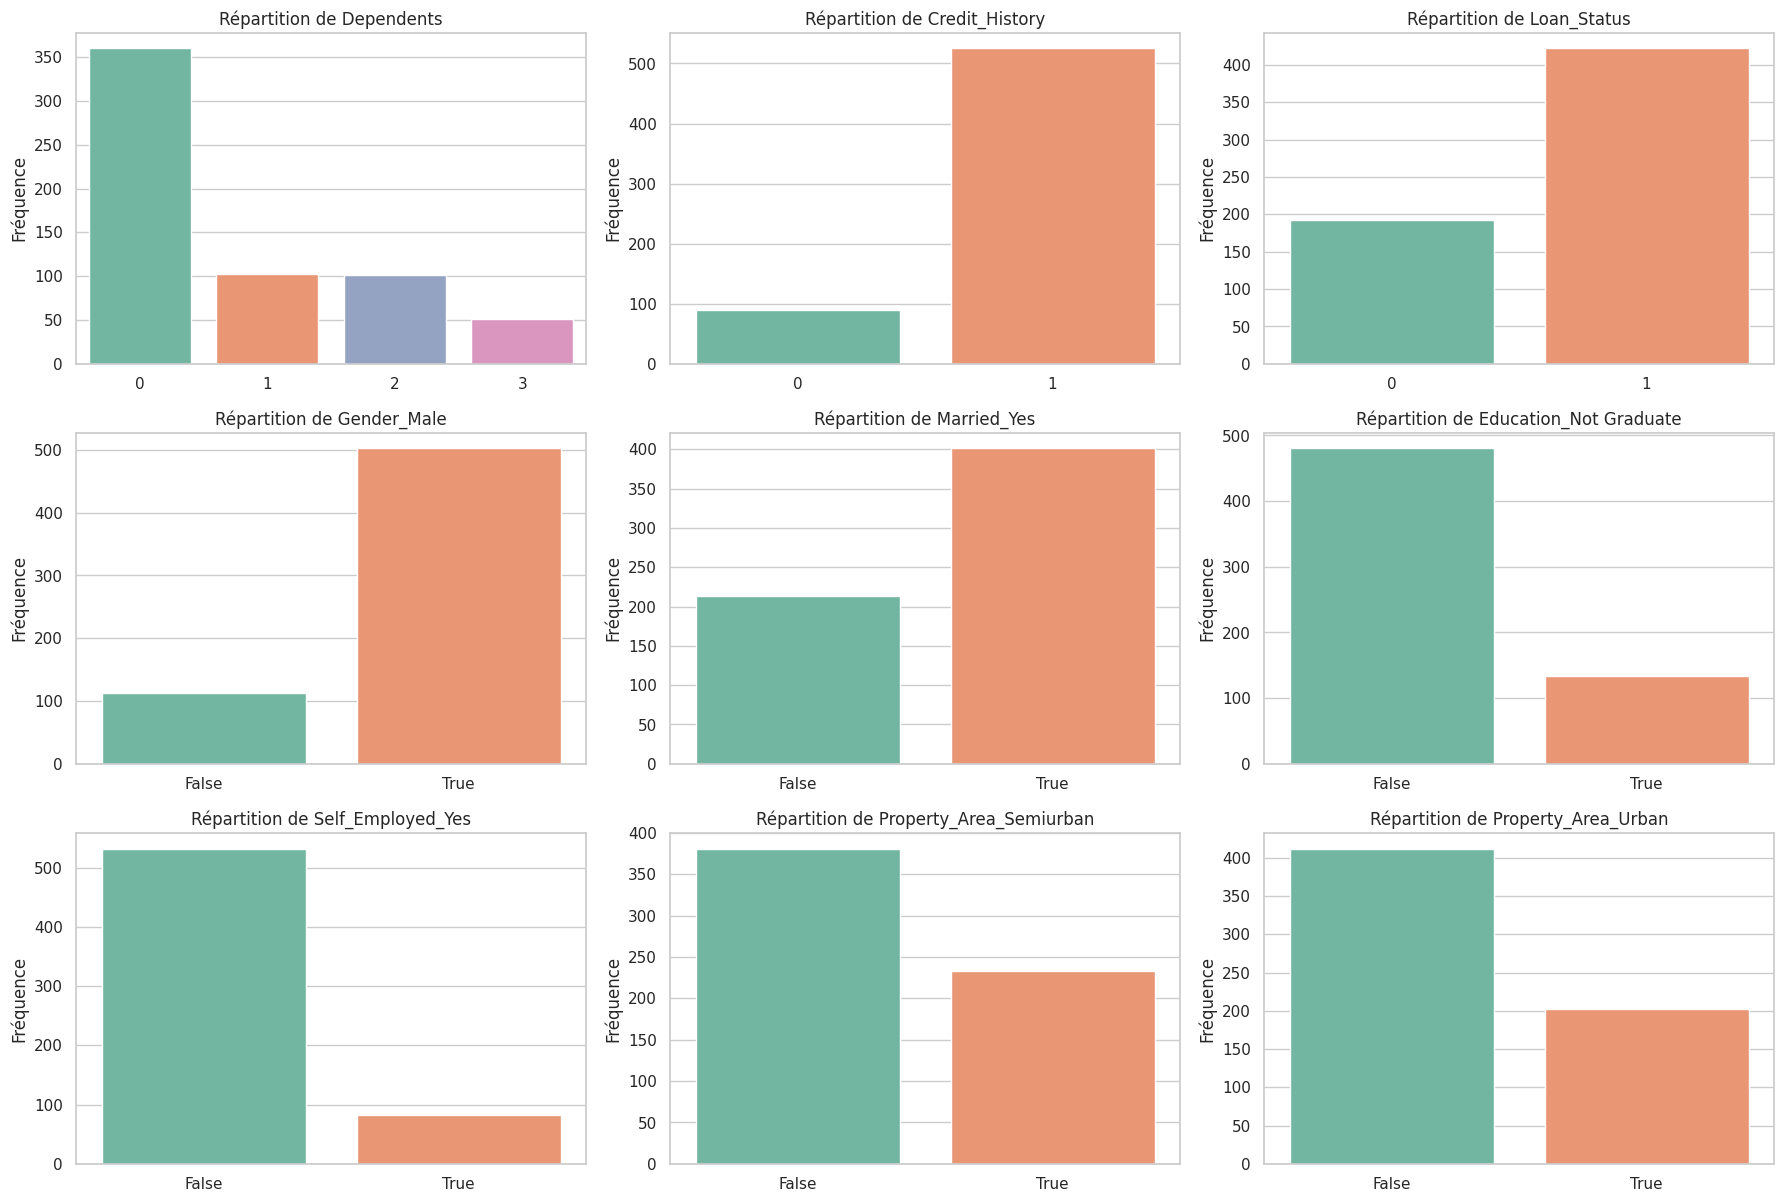

In [20]:
# Visualisation de la distribution des variables catégorielles
var_a_visualiser = df.drop(columns = ["ApplicantIncome", "CoapplicantIncome", "Loan_Amount_Term", "LoanAmount"])

# Mosaïque de graphiques
sns.set(style="whitegrid", palette = "pastel")
# Nbr_graph_par_ligne = 3
n_cols = 3
n_rows = int(np.ceil(len(var_a_visualiser) / n_cols))
plt.figure(figsize=(18, n_rows * 4))
for i, var_a_visualiser in enumerate(var_a_visualiser, 1):
  plt.subplot(n_rows, n_cols, i)
  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
  plt.title(f"Répartition de {var_a_visualiser}")
  plt.xlabel("")
  plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

L'analyse de la distributions des variables nous permet d'établir les constatations suivantes :  
* L'écrasante majorité des candidats n'ont pas de personnes à charge (dependents).    
* Plus de 80% ont déjà eu un crédit auparavant (credit_history).
* La plupart des prêts ont été approuvés (Loan_Status).
* Il y a presque 5 fois plus d'hommes que de femmes (Gender_Male).
* Il y a quasiment 2 fois plus de demandeurs de prêts mariés que le contraire (Married_Yes).
* La plupart des potentiels prêteurs ont un niveau d’éducation élevé (Education_Not Graduate).
* Moins d'une personne sur 5 est auto-entrepreneur (Self_Employed_Yes).
* La répartition géographique des biens est relativement équilibrée, avec un léger avantage pour les zones semi-urbaines.

Ces premières observations offrent une vue d’ensemble du profil type des emprunteurs dans l’échantillon, avant toute analyse de relation entre variables.

Désormais, on va observer les variables numériques.

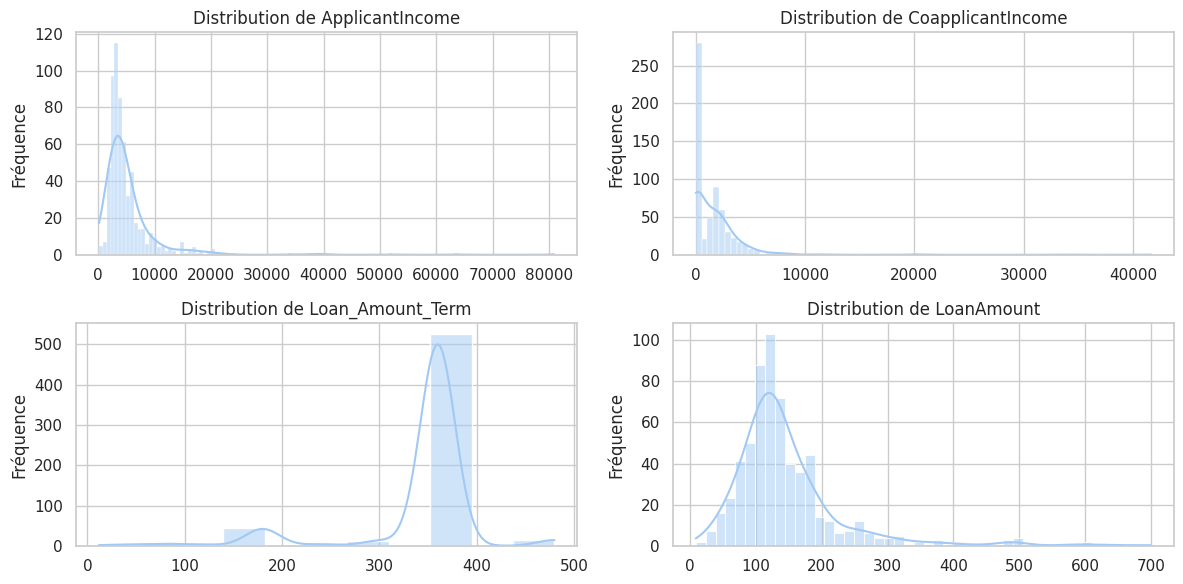

In [21]:
# Visualisation de la distribution des variables numériques
var_num = df[["ApplicantIncome", "CoapplicantIncome", "Loan_Amount_Term", "LoanAmount"]]

# Affichage des figures en 2x2
plt.figure(figsize=(12,6))
n_col = 2
n_ligne = 2
for i, n_cols in enumerate(var_num, 1):
  plt.subplot(n_ligne, n_col, i)
  sns.histplot(var_num[n_cols], kde=True)
  plt.title(f"Distribution de {n_cols}")
  plt.xlabel("")
  plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

On observe que la distribution n'est pas symétrique, et plus précisément asymétrique vers la droite. On constate également des revenus ou montants très élevés (valeurs aberrantes).

## 2 - Rendre la distribution plus symétrique et diminuer l'impact des valeurs aberrantes




In [22]:
# Application de la méthode log1p pour nos variables numériques
var_num = np.log1p(var_num)
var_num.head()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,LoanAmount
0,8.674197,0.000000,5.888878,4.859812
1,8.430327,7.319202,5.888878,4.859812
2,8.006701,0.000000,5.888878,4.204693
3,7.857094,7.765993,5.888878,4.795791
4,8.699681,0.000000,5.888878,4.955827


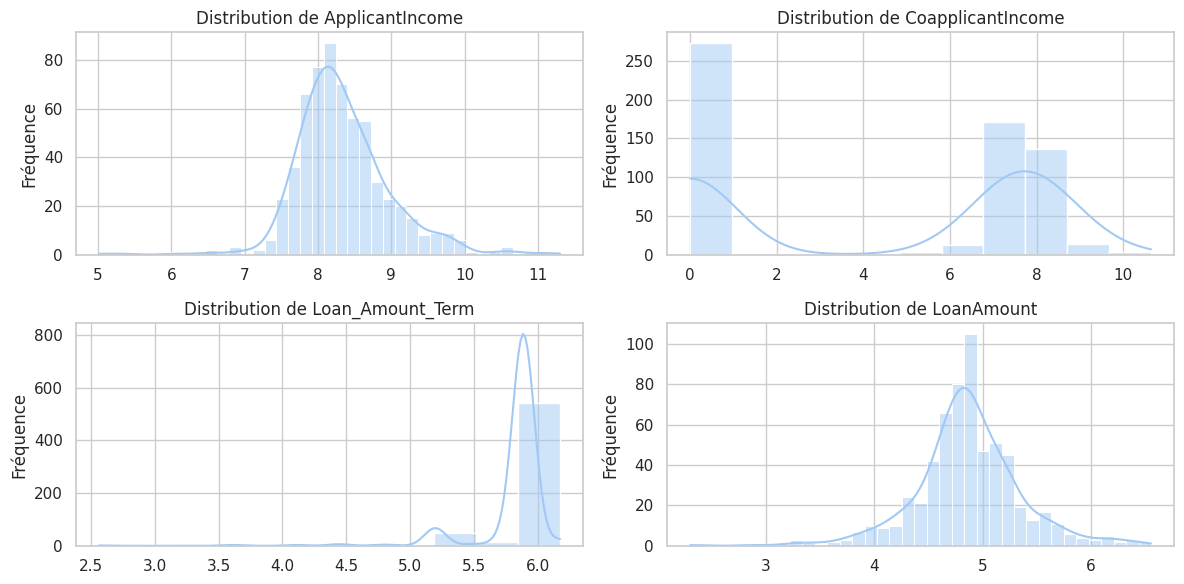

In [23]:
# Re-affichage des figures en 2x2
plt.figure(figsize=(12,6))
n_col = 2
n_ligne = 2
for i, n_cols in enumerate(var_num, 1):
  plt.subplot(n_ligne, n_col, i)
  sns.histplot(var_num[n_cols], kde=True)
  plt.title(f"Distribution de {n_cols}")
  plt.xlabel("")
  plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

Transformation logarithmique du revenu (ApplicantIncome)

Le revenu des demandeurs présente une forte asymétrie :
la majorité des clients ont un revenu faible à moyen, tandis qu’un petit nombre ont des revenus très élevés.

Ces valeurs extrêmes peuvent influencer les analyses et fausser certains modèles de machine learning.

Pour corriger cela, nous appliquons une transformation logarithmique.

🎯 Objectif

Rendre la distribution du revenu plus symétrique (plus proche d’une distribution normale).

Améliorer la lisibilité des visualisations (histogrammes, boxplots, etc.).

Faciliter la modélisation, notamment pour les algorithmes sensibles à la variance comme la régression linéaire ou logistique.

## 3 - Comparer les revenus entre éligibles et non éligibles
Objectif → voir si les revenus influencent la décision de prêt, en prenant en compte qu'il y a le revenu du demandeur seul et les revenus du demandeur + codemandeur.

/tmp/ipython-input-3506253135.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Loan_Status", y = "ApplicantIncome", data = df, palette = "Set2")
/tmp/ipython-input-3506253135.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Loan_Status", y = "TotalIncome", data = df, palette = "Set2")


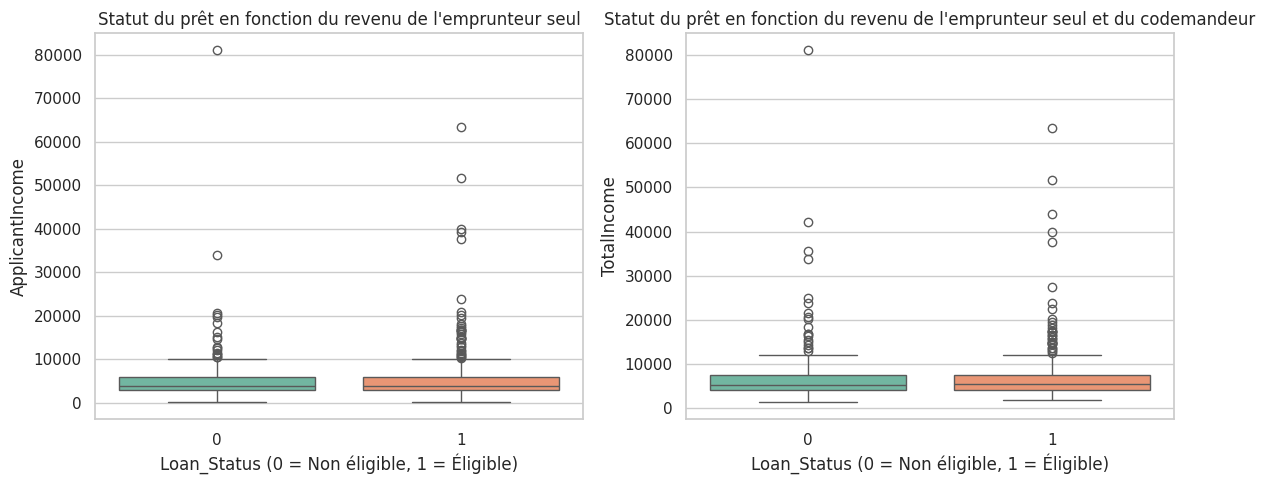

In [24]:
plt.figure(figsize=(12, 5))

# Revenu de l'emprunteur seul
plt.subplot(1,2,1)
sns.boxplot(x = "Loan_Status", y = "ApplicantIncome", data = df, palette = "Set2")
plt.title("Statut du prêt en fonction du revenu de l'emprunteur seul")
plt.xlabel("Loan_Status (0 = Non éligible, 1 = Éligible)")
plt.ylabel("ApplicantIncome")

# Revenu de l'emprunteur seul et du codemandeur
plt.subplot(1,2,2)
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
sns.boxplot(x = "Loan_Status", y = "TotalIncome", data = df, palette = "Set2")
plt.title("Statut du prêt en fonction du revenu de l'emprunteur seul et du codemandeur")
plt.xlabel("Loan_Status (0 = Non éligible, 1 = Éligible)")
plt.ylabel("TotalIncome")

plt.tight_layout()
plt.show()

Concernant l'analyse de ces graphiques,
* Sur le deuxième graphique (TotalIncome), la différence entre les deux groupes (0 et 1) est plus visible et montre que les revenus combinés du foyer influencent davantage la décision d’éligibilité que le revenu individuel seul.
* Pour l'emprunteur seul, la médiane du revenu est presque la même pour les deux groupes. Cela signifie que les personnes qui ont un prêt accordé/refusé gagnent en moyenne des revenus similaires.

Cela nous indique que le revenu n’est pas un critère suffisant pour prédire l’éligibilité au prêt.


Maintenant, on passe à l'étudie de l'impact des variables Credit_History et Education.

## 4 - Analyser l'impact des variables Credit_History et Education

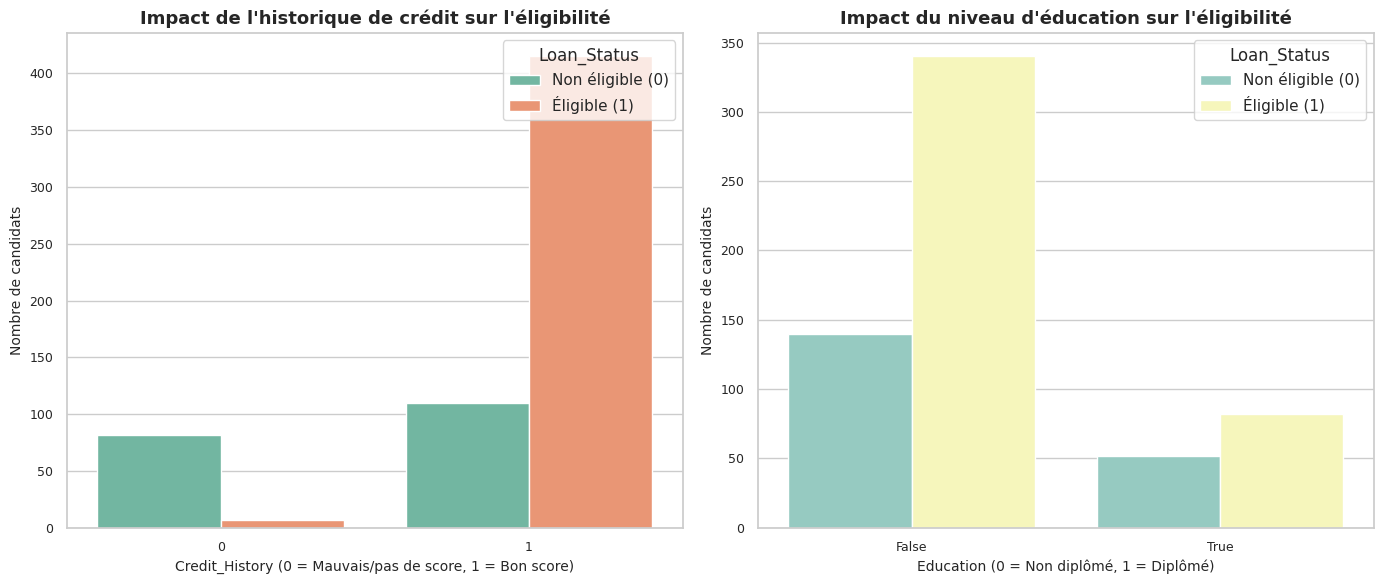

In [25]:
plt.figure(figsize=(14, 6))

# Impact de "Credit_History"
plt.subplot(1, 2, 1)
sns.countplot(x="Credit_History",hue="Loan_Status",data=df,palette="Set2")
plt.title("Impact de l'historique de crédit sur l'éligibilité", fontsize=13, weight='bold')
plt.xlabel("Credit_History (0 = Mauvais/pas de score, 1 = Bon score)", fontsize=10)
plt.ylabel("Nombre de candidats", fontsize=10)
plt.legend(title="Loan_Status", labels=["Non éligible (0)", "Éligible (1)"], loc="upper right")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Impact de "Education"
plt.subplot(1, 2, 2)
sns.countplot(x="Education_Not Graduate",hue="Loan_Status",data=df,palette="Set3")
plt.title("Impact du niveau d'éducation sur l'éligibilité", fontsize=13, weight='bold')
plt.xlabel("Education (0 = Non diplômé, 1 = Diplômé)", fontsize=10)
plt.ylabel("Nombre de candidats", fontsize=10)
plt.legend(title="Loan_Status", labels=["Non éligible (0)", "Éligible (1)"], loc="upper right")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

Les candidats disposant d’un bon historique de crédit (Credit_History = 1) ont largement plus de chances d’obtenir un prêt que ceux ayant un mauvais historique.
Cela montre que la fiabilité financière passée est un critère décisif dans l’attribution des crédits.

Le niveau d’éducation semble avoir un impact modéré : les candidats diplômés obtiennent légèrement plus souvent un prêt que les non diplômés.
Cette tendance pourrait être liée à une stabilité professionnelle plus élevée ou à une meilleure capacité de gestion financière.

Globalement, parmi les deux variables étudiées, Credit_History se distingue clairement comme la plus déterminante dans la décision d’éligibilité.

Désormais, nous allons vérifier que la répartition des classes dans Loan_Status

## 5 - Etude de la répartition des classes dans Loan_Status

/tmp/ipython-input-4182771995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Loan_Status", data=df, palette="Set2")


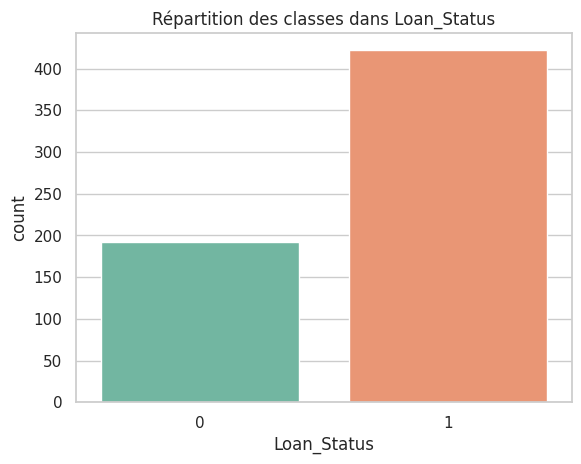

Loan_Status
1    422
0    192
Name: count, dtype: int64


In [26]:
# Répartition des classes dans la variable Loan_Status
sns.countplot(x="Loan_Status", data=df, palette="Set2")
plt.title("Répartition des classes dans Loan_Status")
plt.show()
print(df["Loan_Status"].value_counts())

Notre variable cible contient plus d'attribution de prêt que de rejet. Il faudrait y faire attention lors de la modélisation.

# Etape 3 : Modélisation

## 1 - Définir la variable cible

Nous savons que notre variable cible est ['Loan_Status'].


In [27]:
y = df['Loan_Status']
X = df.drop(columns = ['Loan_Status'])

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X.head()

Shape de X: (614, 13)
Shape de y: (614,)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome
0,0,5849,0,128,360,1,True,False,False,False,False,True,5849
1,1,4583,1508,128,360,1,True,True,False,False,False,False,6091
2,0,3000,0,66,360,1,True,True,False,True,False,True,3000
3,0,2583,2358,120,360,1,True,True,True,False,False,True,4941
4,0,6000,0,141,360,1,True,False,False,False,False,True,6000


## 2 - Séparer les données train/test

Nous allons utiliser 80% des données pour l'entrainement (train) et les 20% restants pour le test.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Vérification des dimensions
print("Dimension de X_train :", X_train.shape)
print("Dimension de y_train :", y_train.shape)
print("Dimension de X_test :", X_test.shape)
print("Dimension de y_test :", y_test.shape)

Dimension de X_train : (491, 13)
Dimension de y_train : (491,)
Dimension de X_test : (123, 13)
Dimension de y_test : (123,)


Détail des paramètres :    
| Paramètre         | Rôle                                                   | Pourquoi c’est important                                                              |
| ----------------- | ------------------------------------------------------ | ------------------------------------------------------------------------------------- |
| `test_size=0.2`   | Garde 20% du jeu pour tester                           | Assez pour une bonne évaluation                                                       |
| `random_state=42` | Fixe le tirage aléatoire                               | Pour obtenir les mêmes résultats à chaque exécution                                   |
| `stratify=y`      | Conserve le même équilibre de classes entre train/test | Indispensable car `Loan_Status` est déséquilibré (plus de prêts accordés que refusés) |


In [29]:
# Vérification de la répartition des 0/1 de la variable Loan_Status dans les deux groupes
print("Répartition dasn y_train :", y_train.value_counts(normalize=True))
print("\nRépartition dans y_test :", y_test.value_counts(normalize=True))

Répartition dasn y_train : Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Répartition dans y_test : Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


## 3 - Tester plusieurs modèles

Notre jeu de données présente les caractéristiques suivantes :    
* Variable cible binaire (Loan_Status) → problème de classification supervisée.
* Variables mixtes (numériques + catégorielles encodées).
* Taille du dataset moyenne (~600 lignes).
* Variables explicatives assez simples (revenus, statut, historique de crédit, etc.).

| Modèle                                     | Type / Famille                     | Points forts 💪                                                                                                | Points faibles ⚠️                                                                   | Besoin de normalisation 📏           | Sensibilité aux valeurs aberrantes ⚡       | Pourquoi l’essayer ici ?                                                    |
| :----------------------------------------- | :--------------------------------- | :------------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------- | :----------------------------------- | :----------------------------------------- | :-------------------------------------------------------------------------- |
| **Régression Logistique**                  | Linéaire                           | - Simple, rapide et interprétable<br>- Fournit des probabilités<br>- Bonne baseline pour comparaison           | - Suppose une relation linéaire<br>- Sensible aux outliers et à la multicolinéarité | ✅ Oui (très recommandé)              | ⚠️ Oui, peut être fortement biaisée        | 🔹 Bon **modèle de référence**, interprétable et facile à expliquer         |
| **K-Nearest Neighbors (KNN)**              | Basé sur la distance               | - Simple, intuitif<br>- Aucune hypothèse sur la forme des données                                              | - Lente si dataset grand<br>- Sensible à l’échelle des données                      | ✅ Oui (obligatoire)                  | ⚠️ Oui, très sensible aux valeurs extrêmes | 🔹 Permet de voir la **structure naturelle** des données (benchmark visuel) |
| **Decision Tree**                          | Arbre de décision                  | - Interprétable<br>- Gère les données mixtes<br>- Pas besoin de normalisation                                  | - Tendance à surapprendre<br>- Légèrement instable seul                             | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Permet de **visualiser les règles de décision** (utile pour ton rapport) |
| **Random Forest**                          | Ensemble d’arbres                  | - Robuste<br>- Gère les non-linéarités et les interactions<br>- Peu de tuning requis                           | - Moins interprétable<br>- Plus lent à entraîner                                    | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Excellent compromis entre **robustesse et performance**                  |
| **Gradient Boosting (XGBoost / LightGBM)** | Ensemble séquentiel d’arbres       | - Très performant sur petits jeux tabulaires<br>- Gère bien le déséquilibre de classes<br>- Feature importance | - Paramétrage complexe<br>- Risque d’overfitting                                    | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Modèle **hautement performant** pour données structurées comme ici       |
| **Support Vector Machine (SVM)**           | Séparateur linéaire / non-linéaire | - Capture des frontières complexes<br>- Performant avec le bon kernel                                          | - Sensible à l’échelle<br>- Lent si dataset large                                   | ✅ Oui (impératif)                    | ⚠️ Oui, fortement influencé                | 🔹 Bon test de **robustesse sur données normalisées**                       |


### Normaliser / standardiser

Cette étape est nécessaire pour les modèles sensibles à l’échelle des variables tel que :
* Régression linéaire
* KNN
* SVM
Pour l'arbre de décision, la forêt aléatoire et le gradient boosting ce n’est pas nécessaire.



In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### A. Régression logistique

In [31]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### B. K-Nearest Neighbors

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

### C. Arbre de décision

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### D. Forêt aléatoire

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### E. Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### F. Support Vector Machine

In [36]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

## 4 - Évaluation des performances des modèles (métriques)

#### Accuracy (Exactitude)
$$
\text{Accuracy} = \frac{TP + TN}{Total} = \frac{40 + 45}{100} = 0.85
$$
➡ **85 % des prédictions sont correctes.**

---

#### Precision (Précision)

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{40}{40 + 5} = 0.888
$$

➡ **Parmi les clients prédits éligibles, 88.8 % le sont vraiment.**

---

#### Recall (Rappel / Sensibilité)

$$
\mathrm{Recall} = \frac{TP}{TP + FN} = \frac{40}{40 + 10} = 0.8
$$

➡ **Le modèle détecte 80 % des clients réellement éligibles.**

---

#### F1 Score

$$
F_1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
= 2 \times \frac{0.888 \times 0.8}{0.888 + 0.8} \approx 0.842
$$

---



➡ **Bon compromis entre précision et rappel.**

---

#### ROC AUC

Représente la capacité du modèle à **séparer les classes** pour tous les seuils possibles.

- Valeur **0.5 → hasard**,  
- Valeur **1 → modèle parfait**.

Dans cet exemple, la **courbe ROC** aurait une **AUC ≈ 0.90**, ce qui indique une excellente capacité de discrimination.

---

### Interprétation générale

| Métrique | Signification | Objectif |
|-----------|----------------|-----------|
| **Accuracy** | Pourcentage global de bonnes prédictions | Élevé (sauf si classes déséquilibrées) |
| **Precision** | Fiabilité des positifs prédits | Élevée si l’on veut éviter les faux positifs |
| **Recall** | Capacité à détecter tous les vrais positifs | Élevée si l’on veut éviter les faux négatifs |
| **F1 Score** | Compromis entre précision et rappel | Utile quand les classes sont déséquilibrées |
| **ROC AUC** | Mesure globale de la capacité de séparation | Proche de 1 = très bon modèle |

---

 **Rappel visuel :**
- **TP (True Positive)** → Prédit positif, réellement positif  
- **TN (True Negative)** → Prédit négatif, réellement négatif  
- **FP (False Positive)** → Prédit positif, mais faux  
- **FN (False Negative)** → Prédit négatif, mais vrai


### A - Comparaison des métriques

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "Régression Logistique": (logreg, X_test_scaled),
    "KNN":                    (knn,    X_test_scaled),
    "SVM":                    (svm,    X_test_scaled),
    "Arbre de décision":      (dt,     X_test),
    "Forêt aléatoire":        (rf,     X_test),
    "Gradient Boosting":      (gb,     X_test),
}

results = []
for name, (model, Xte) in models.items():
    # 1) Prédictions classes
    y_pred = model.predict(Xte)

    # 2) Score continu pour ROC-AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(Xte)
    else:
        y_score = None

    # 3) Métriques
    row = {
        "Modèle":    name,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall":    recall_score(y_test, y_pred),
        "F1-score":  f1_score(y_test, y_pred),
        "ROC-AUC":   (roc_auc_score(y_test, y_score) if y_score is not None else None),
    }
    results.append(row)

# Création du DataFrame de comparaison
comparison_df = pd.DataFrame(results)
display(comparison_df)


,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Régression Logistique,0.861789,0.840000,0.988235,0.908108,0.848607
1,KNN,0.845528,0.836735,0.964706,0.896175,0.767337
2,SVM,0.853659,0.831683,0.988235,0.903226,0.851703
3,Arbre de décision,0.723577,0.831169,0.752941,0.790123,0.705418
4,Forêt aléatoire,0.853659,0.868132,0.929412,0.897727,0.823220
5,Gradient Boosting,0.837398,0.849462,0.929412,0.887640,0.793189


### B - Comparaison des courbes AUC

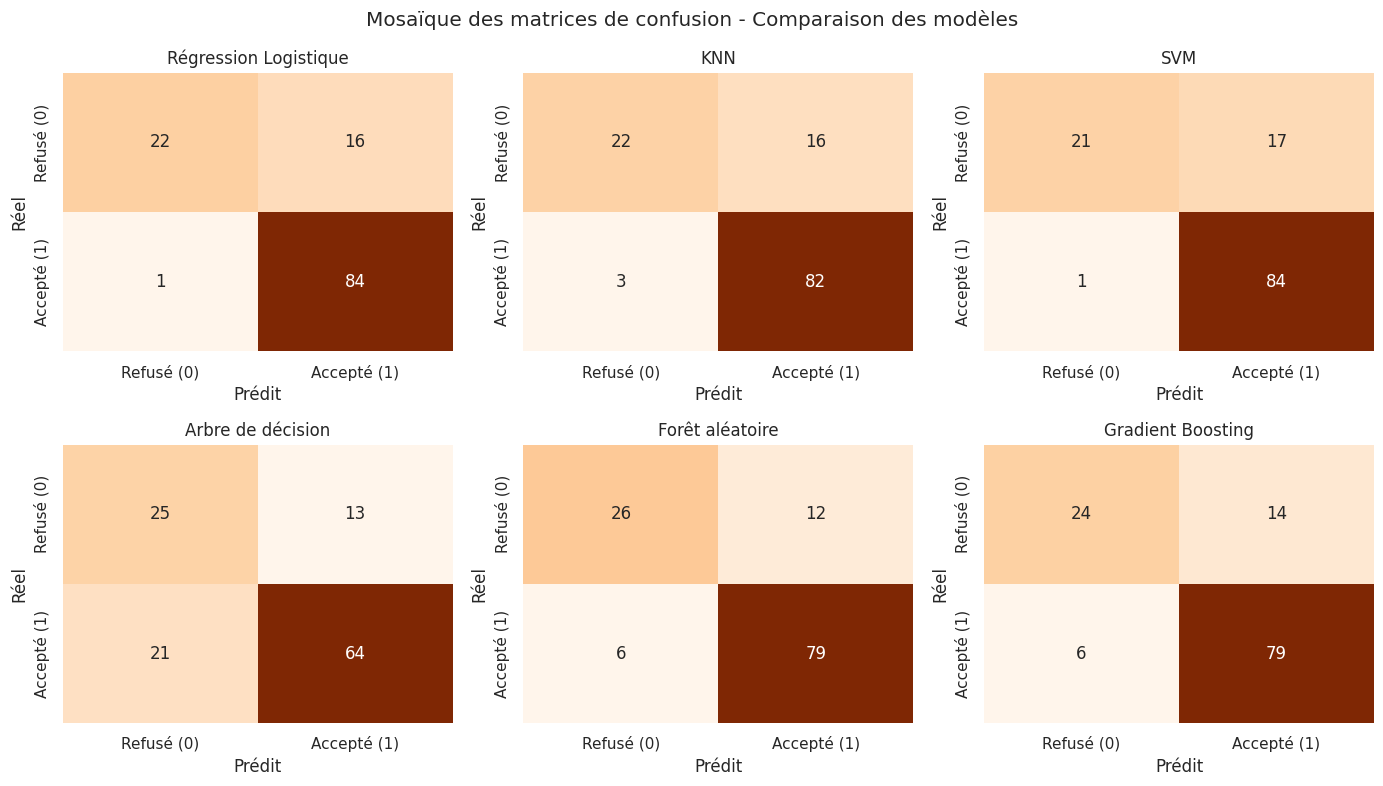

In [40]:
from sklearn.metrics import confusion_matrix

items = list(models.items())
fig,axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.flatten()

for i, (name, (model, Xte)) in enumerate(items):
  y_pred = model.predict(Xte)
  cm = confusion_matrix(y_test, y_pred)

  sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False, ax=axes[i],xticklabels=["Refusé (0)", "Accepté (1)"], yticklabels=["Refusé (0)", "Accepté (1)"])
  axes[i].set_title(name)
  axes[i].set_xlabel("Prédit")
  axes[i].set_ylabel("Réel")

plt.suptitle("Mosaïque des matrices de confusion - Comparaison des modèles")
plt.tight_layout()
plt.show()

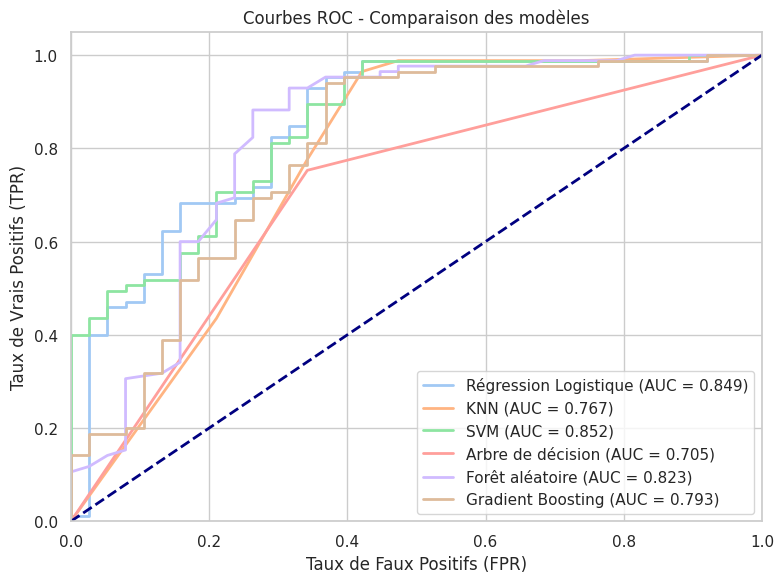

In [41]:
# COURBES ROC SIMPLIFIÉES
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, (model, Xte) in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(Xte)
    else:
        continue

    # Calcul des points de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC du modèle
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Tracer la diagonale de référence (modèle aléatoire)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Personnalisation du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Comparaison des modèles')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### C - Interprétation

L’évaluation des différents modèles de machine learning a permis d’obtenir des résultats contrastés selon les métriques considérées (Accuracy, F1-score, Recall et AUC). L’objectif étant d’identifier le modèle le plus robuste et le plus fiable pour la prédiction de l’éligibilité à un prêt, l’analyse suivante classe les modèles du plus au moins performant.

Le **Random Forest** se distingue nettement comme le modèle le plus performant. Il présente une **excellente capacité de discrimination** entre les emprunteurs éligibles et non éligibles, comme le confirme sa **valeur AUC élevée**. Son **F1-score équilibré** montre qu’il maintient un bon compromis entre précision et rappel, ce qui traduit une performance stable sur l’ensemble des classes. De plus, sa nature d’ensemble d’arbres lui confère une **robustesse accrue** face aux valeurs aberrantes et aux corrélations entre variables. Ce modèle combine ainsi **haute performance, stabilité et généralisation**, ce qui en fait le choix le plus adapté pour ce projet.

Le **Gradient Boosting** arrive en seconde position, avec des performances très proches de celles du Random Forest. Il présente également un **AUC élevé** et une bonne sensibilité, traduisant une capacité fine à identifier les emprunteurs réellement éligibles. Toutefois, son **temps d’entraînement plus long** et sa **moindre interprétabilité** limitent son avantage opérationnel, malgré une précision légèrement supérieure sur certaines classes.

En troisième position, la **régression logistique** constitue une approche simple, rapide et bien calibrée. Ses résultats sont globalement corrects, avec une **bonne précision** mais un **rappel plus faible**, traduisant une tendance à sous-estimer certains cas positifs. Ce modèle reste néanmoins un **excellent point de comparaison** et conserve une interprétabilité appréciable, notamment pour des contextes nécessitant de la transparence décisionnelle.

L’**arbre de décision** arrive juste après. Bien qu’il soit très interprétable et visuellement explicatif, il souffre d’un **phénomène de surapprentissage** et d’une **généralisation plus limitée**. Ses performances restent correctes, mais son **AUC plus faible** reflète une séparation moins nette des classes.

Le **SVM** obtient une bonne précision brute, mais il est **sensible à la normalisation** et montre un **rappel plus faible**, ce qui indique qu’il identifie mal certains profils éligibles. Il reste toutefois efficace pour des séparations linéaires simples.

Enfin, le **KNN** se révèle le moins performant dans ce contexte. Malgré sa simplicité et son caractère intuitif, il montre une **faible stabilité** et une **dépendance importante à la normalisation** des données. Ses résultats sont globalement en deçà des autres modèles, notamment en termes de rappel et de F1-score.

### D - Conclusion

En conclusion, le Random Forest apparaît comme le modèle le plus adapté pour la prédiction de l’éligibilité à un prêt bancaire.
Il combine excellente performance (AUC élevé), bonne précision globale, et robustesse face aux variations des données.
Son équilibre entre interprétabilité relative et puissance de modélisation en fait une solution particulièrement pertinente pour un déploiement en contexte réel.

Cependant, la Régression Logistique reste une alternative intéressante si l’objectif est d’avoir un modèle plus simple, rapide et facilement interprétable.

Une optimisation des hyperparamètres (GridSearch, RandomSearch, Bayesian tuning) pourrait encore améliorer les résultats pour les modèles d’ensemble.

# Etape 4 : Optimisation

## 1 - Ingénierie des caractéristiques (feature engineering)
Le feature engineering consiste à créer une ou plusieurs nouvelles variables à partir de celle déjà existantes, dans le but d'améliorer la prédiction du modèle.


Une nouvelle variable pertinente serait `Income-to-Loan-Ratio`.

Cette variable représente la **capacité réelle de remboursement du demandeur** : plus ce ratio est élevé, plus l’emprunteur a des revenus proportionnellement supérieurs au montant demandé → plus il est solvable.

Formule :
$$
\text{Income-to-Loan-Ratio} = \frac{ApplicantIncome + CoapplicantIncome}{LoanAmount}
$$

In [44]:
# Création de la variable Income-to-Loan-Ratio
df["Income-to-Loan-Ratio"] = (df["ApplicantIncome"] + df["CoapplicantIncome"]) / df["LoanAmount"]

# Vérification rapide
print(df[["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Income-to-Loan-Ratio"]].head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Income-to-Loan-Ratio
0             5849                  0         128             45.695312
1             4583               1508         128             47.585938
2             3000                  0          66             45.454545
3             2583               2358         120             41.175000
4             6000                  0         141             42.553191
